# Use different metrics to benchmark signature connectivity metrics

The gold standard is the drug MoA from Corsello et al.: https://www.nature.com/nm/journal/v23/n4/full/nm.4306.html

In [1]:
import os, sys, json
from itertools import combinations
import h5py
from pymongo import MongoClient
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import distance
np.random.seed(10)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 ## Output Type 3 (Type3) or Type 42 (TrueType)
rcParams['font.sans-serif'] = 'Arial'

import seaborn as sns
sns.set_context('talk', font_scale=1.5)


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from joblib import delayed, Parallel

# Implement connectivity metrics 

Connectivity Metrics between a pair of signatures:

`sig1` and `sig2` are 1-D `np.array` with same orders of genes


In [29]:
def _gesa_enrichment_score(ranks_s):
    '''Calculate enrichment score from a rank ordered boolean array.
    ranks_s: np.array([0., 1., 0., 0.])
        - 1.: hits
        - 0.: misses
    '''
    n_hits = ranks_s.sum()
    n_misses = ranks_s.shape[0] - n_hits
    
    p_hit = np.cumsum(ranks_s) / n_hits
    p_miss = np.cumsum(1 - ranks_s) / n_misses
    p_diff = np.absolute(p_hit - p_miss)
    idx = np.argmax(p_diff)
    es = p_hit[idx] - p_miss[idx]
    return es
    
def gsea_score(sig1, sig2, n_sig=100):
    '''GSEA-based Kolmogorov-Smirnov statsitics.
    n_sig: number of top ranked genes to be treated as significant
    '''
    # number of genes
    n = len(sig1)
    # rank genes in sig1 (0: most down gene, 977: most up genes)
    ranks1 = stats.rankdata(sig1) - 1 
    # identify top up/down genes in sig1
    sig1_down = ranks1 < n_sig
    sig1_up = ranks1 > (n-1-n_sig)
    # argsort sig2
    sig2_srt_idx = sig2.argsort()
    # Compute ES: sig1 as query, sig2 as ref rank
    es_up1 = _gesa_enrichment_score( sig1_up[sig2_srt_idx].astype(float) )
    es_down1 = _gesa_enrichment_score( sig1_down[sig2_srt_idx].astype(float) )
    
    # rank genes in sig2
    ranks2 = stats.rankdata(sig2) - 1
    # identify top up/down genes in sig2
    sig2_down = ranks2 < n_sig
    sig2_up = ranks2 > (n-1-n_sig)
    # argsort sig1
    sig1_srt_idx = sig1.argsort()
    # Compute ES: sig2 as query, sig1 as ref rank
    es_up2 = _gesa_enrichment_score( sig2_up[sig1_srt_idx].astype(float) )
    es_down2 = _gesa_enrichment_score( sig2_down[sig1_srt_idx].astype(float) )
    
#     print es_up1, es_down1
#     print es_up2, es_down2
    
    # es_up is using up gene set to find hits in a list ascending ordered, 
    # therefore, the desirable sign should be negative
    score = (es_down1 - es_up1 + es_down2 - es_up2) / 4. 
    return score

def cosine_sim(sig1, sig2):
    '''Cosine similarity'''
    return 1 - distance.cosine(sig1, sig2)

def correlation(sig1, sig2):
    '''Pearson correlation'''
    return 1 - distance.correlation(sig1, sig2)

def pscore(mat, func, n_jobs=1, **kwargs):
    '''mat is a signature by gene matrix, apply func to all pairwise signatures.
    Similar to pdist
    '''
    n = mat.shape[0]
    n_scores = n * (n-1) / 2
    scores = np.zeros(n_scores)
    c = 0
    if n_jobs == 1:
        for i, j in combinations(range(n), 2):
            scores[c] = func(mat[i], mat[j])
            c += 1
    else:
        scores = Parallel(n_jobs=n_jobs, backend='multiprocessing', verbose=10)(
            delayed(func)(mat[i], mat[j], **kwargs) for i, j in combinations(range(n), 2))
        scores = np.array(scores)
    return scores

## Check the metrics with random data

In [4]:
sig1 = np.random.randn(978)
sig2 = np.random.randn(978)
sig3 = sig1 + 1.

In [5]:
gsea_score(sig1, sig2, n_sig=50)

0.12504310344827588

In [6]:
print gsea_score(sig1, sig3, n_sig=50)
print cosine_sim(sig1, sig3)
print cosine_sim(sig1, sig1 * 2)
print correlation(sig1, sig3)

1.0
0.677393930887
1.0
1.0


In [7]:
n_sigs = [10, 20, 50, 100]

all_scores = np.zeros((1000, 6))
for i in range(1000):
    sig_n = np.random.randn(978)
    
    es_10 = gsea_score(sig1, sig_n, n_sig=10)
    es_20 = gsea_score(sig1, sig_n, n_sig=20)
    es_50 = gsea_score(sig1, sig_n, n_sig=50)
    es_100 = gsea_score(sig1, sig_n, n_sig=100)
    
    cos = cosine_sim(sig1, sig_n)
    corr = correlation(sig1, sig_n)
    
    all_scores[i] = [es_10, es_20, es_50, es_100, cos, corr]
    
    

In [8]:
all_scores_df = pd.DataFrame(all_scores, 
                             columns=['ES_10', 'ES_20', 'ES_50', 'ES_100', 'cosine', 'correlation'])


/usr/local/lib/python2.7/site-packages/seaborn/categorical.py:1791: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


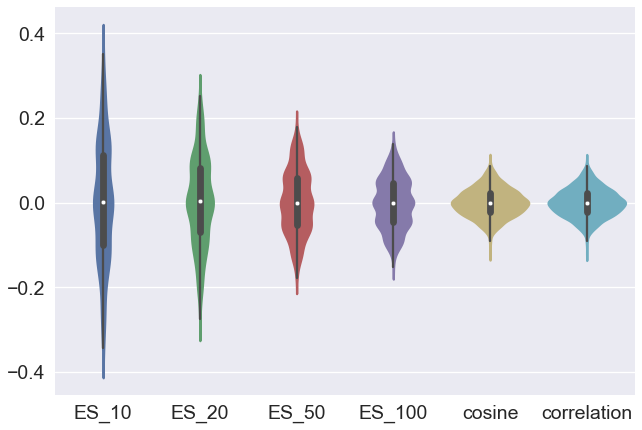

In [9]:
sns.violinplot(all_scores_df)

In [10]:
del all_scores_df

# Read gold standard of drug MoAs

In [14]:
drug_moa_df = pd.read_csv('../../Repurposing_Hub_export.txt', sep='\t')
print drug_moa_df.shape
drug_moa_df.head()

(5628, 5)


,Name,MOA,Target,Id,Phase
0,A-317491,purinergic receptor antagonist,P2RX3,"BRD-K38019854-323-01-4, BRD-K38019854-001-01-6",Preclinical
1,A-33903,NaN,NaN,BRD-A40302156-001-01-9,Phase 2
2,A-366,histone lysine methyltransferase inhibitor,"EHMT1, EHMT2","BRD-K06182768-001-02-3, BRD-K06182768-001-01-5...",Preclinical
3,A-674563,AKT inhibitor,"AKT1, PKIA, PRKACA",BRD-K78177893-001-02-4,Preclinical
4,A-7,calmodulin antagonist,NaN,BRD-K03301001-003-02-5,Preclinical


In [15]:
drug_moa_df['pert_ids'] = drug_moa_df['Id']\
    .map(lambda x: ','.join(set(['-'.join(item.split('-')[0:2]) for item in x.split(', ')])))

drug_moa_df['pert_id_count'] = drug_moa_df['pert_ids']\
    .map(lambda x: len(x.split(',')))

drug_moa_df['pert_id_count'].value_counts()

1    5179
2     359
3      75
4      11
5       4
Name: pert_id_count, dtype: int64

In [16]:
drug_moa_df.query('pert_id_count > 1').head()

,Name,MOA,Target,Id,Phase,pert_ids,pert_id_count
7,abacavir,nucleoside reverse transcriptase inhibitor,NaN,"BRD-A95032015-065-01-2, BRD-K17443395-065-01-4",Launched,"BRD-A95032015,BRD-K17443395",2
13,abiraterone-acetate,androgen biosynthesis inhibitor,CYP17A1,"BRD-K24048528-001-01-7, BRD-K16133773-001-01-9",Launched,"BRD-K24048528,BRD-K16133773",2
26,acadesine,AMPK activator,NaN,"BRD-K53448858-001-07-0, BRD-K04797704-001-01-9",Phase 3,"BRD-K53448858,BRD-K04797704",2
30,acarbose,glucosidase inhibitor,"AMY2A, GAA, MGAM, SI","BRD-A16444946-001-09-7, BRD-K01621533-001-01-1...",Launched,"BRD-K01621533,BRD-K44276885,BRD-A16444946",3
34,aceclidine,acetylcholine receptor agonist,"CHRM1, CHRM2, CHRM3, CHRM4, CHRM5","BRD-A32673558-003-03-9, BRD-A32673558-001-02-5...",Launched,"BRD-K68075732,BRD-A80567352,BRD-A32673558",3


In [17]:
for col in drug_moa_df.columns:
    print col, drug_moa_df[col].nunique()

Name 5628
MOA 1262
Target 2149
Id 5628
Phase 8
pert_ids 5620
pert_id_count 5


In [18]:
drug_moa_df.count()

Name             5628
MOA              5086
Target           4020
Id               5628
Phase            5627
pert_ids         5628
pert_id_count    5628
dtype: int64

In [19]:
drug_moa_df.set_index('Name', inplace=True)

In [20]:
# A dict from pert_id to name
d_pert_name = {}
for name, row in drug_moa_df.iterrows():
    for pert_id in row['pert_ids'].split(','):
        d_pert_name[pert_id] = name
print len(d_pert_name)

6172


# Load signature data and metadata from MongoDB

1. **chdirLm**: CD signatures created by Qiaonan
2. **CD_nocenter_LM**: CD signatures of treatment samples vs other treatment samples in the batch as controls
3. **CD_center_LM**: Same with 2., but perform CD after mean centering
4. **avg_center_LM**: Mean center treatment samples in the batch, then use the mean differences as signature

In [5]:
def retrieve_signature_meta_df(coll, query):
    cur = coll.find(query, 
                    {'sig_id':True,
                     'pert_id':True,
                     '_id':False
                    })
    meta_df = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
    print meta_df.shape
    
    meta_df['batch'] = meta_df.index.map(lambda x: x.split(':')[0])
    meta_df['batch_prefix'] = meta_df['batch'].map(lambda x:x.split('_')[0])
    meta_df['cell_id'] = meta_df['batch'].map(lambda x:x.split('_')[1])
    meta_df['time'] = meta_df['batch'].map(lambda x:x.split('_')[2])
    return meta_df

In [6]:
# CD signatures produced by Qiaonan 
client = MongoClient('mongodb://146.203.54.131:27017/')
coll = client['L1000CDS2']['cpcd-gse70138']

meta_df = retrieve_signature_meta_df(coll, {'pert_type': 'trt_cp'})
print meta_df.shape
meta_df.head()

(117126, 1)
(117126, 5)


,pert_id,batch,batch_prefix,cell_id,time
sig_id,,,,,
CPC001_HA1E_24H:BRD-A82329351:10.0,BRD-A82329351,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K02607075:10.0,BRD-K02607075,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-A49906757:10.0,BRD-A49906757,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K85242180:10.0,BRD-K85242180,CPC001_HA1E_24H,CPC001,HA1E,24H
CPC001_HA1E_24H:BRD-K78844995:10.0,BRD-K78844995,CPC001_HA1E_24H,CPC001,HA1E,24H


In [86]:
# coll = client['L1000CDS2']['cpcd-gse70138']
# coll.distinct('pert_type')

[u'trt_poscon', u'trt_cp']

In [7]:
coll_fwd = client['L1000FWD']['sigs']

In [8]:
meta_df_fwd = retrieve_signature_meta_df(coll_fwd, {})
print meta_df_fwd.shape
meta_df_fwd.head()

(127963, 1)
(127963, 5)


,pert_id,batch,batch_prefix,cell_id,time
sig_id,,,,,
CVD001_HUH7_24H:BRD-K07762753-001-03-6:50,BRD-K07762753,CVD001_HUH7_24H,CVD001,HUH7,24H
CVD001_HUH7_24H:BRD-A04706586-236-01-7:10,BRD-A04706586,CVD001_HUH7_24H,CVD001,HUH7,24H
CVD001_HUH7_24H:BRD-A04706586-236-01-7:2.5,BRD-A04706586,CVD001_HUH7_24H,CVD001,HUH7,24H
CVD001_HUH7_24H:BRD-A49680073-001-01-9:10,BRD-A49680073,CVD001_HUH7_24H,CVD001,HUH7,24H
CVD001_HUH7_24H:BRD-A49680073-001-01-9:2.5,BRD-A49680073,CVD001_HUH7_24H,CVD001,HUH7,24H


In [9]:
print meta_df['batch'].nunique(), meta_df_fwd['batch'].nunique()

371 650


In [10]:
print meta_df['batch_prefix'].nunique(), meta_df_fwd['batch_prefix'].nunique()
shared_batch_prefix = set(meta_df['batch_prefix'].unique()) & set(meta_df_fwd['batch_prefix'].unique())
print len(shared_batch_prefix)


28 123
23


In [11]:
print meta_df['pert_id'].nunique(), meta_df_fwd['pert_id'].nunique()
shared_pert_ids = set(meta_df['pert_id'].unique()) & set(meta_df_fwd['pert_id'].unique())
print len(shared_pert_ids)

5907 5242
5236


In [12]:
# Subset the two meta_df to keep only shared pert_id and batch_prefix
meta_df = meta_df.loc[meta_df['batch_prefix'].isin(shared_batch_prefix) & meta_df['pert_id'].isin(shared_pert_ids)]
print meta_df.shape

meta_df_fwd = meta_df_fwd.loc[meta_df_fwd['batch_prefix'].isin(shared_batch_prefix) & meta_df_fwd['pert_id'].isin(shared_pert_ids)]
print meta_df_fwd.shape

(105514, 5)
(104790, 5)


## Signature connectivity scores of same drug on 

1. **Same batch**: same (batch_prefix:cell_id)
2. **Different batch**: same cell_id, different batch_prefix

In [27]:
def retrieve_sig_mat(sig_ids, coll, key):
    '''Retrieve signatures matrix from MongoDB'''
    # Retrieve signature matrix
    sig_mat = np.zeros((len(sig_ids), 978))
    for i, sig_id in enumerate(sig_ids): 
        doc = coll.find_one({'sig_id': sig_id}, {'_id':False, key:True})
        sig_mat[i] = doc[key]
    return sig_mat
    
def compute_connectivity_scores_same_drug_same_batch(meta_df, coll, key):
    '''key is field in the coll that store the signature array'''
    res_same_batch = {
        'cosine': np.array([]),
        'corr': np.array([]),
        'ES50': np.array([]),
    }
    grouped = meta_df.groupby(['batch_prefix', 'cell_id', 'pert_id'])

    c = 0
    for group, sub_df in grouped:
        if sub_df.shape[0] > 1:
            sig_ids = sub_df.index.tolist()
            sig_mat = retrieve_sig_mat(sig_ids, coll, key)

            scores_cosine = pscore(sig_mat, cosine_sim)
            scores_corr = pscore(sig_mat, correlation)
            scores_es50 = pscore(sig_mat, lambda x, y: gsea_score(x, y, 50))

            res_same_batch['cosine'] = np.hstack((res_same_batch['cosine'], scores_cosine))
            res_same_batch['corr'] = np.hstack((res_same_batch['corr'], scores_corr))
            res_same_batch['ES50'] = np.hstack((res_same_batch['ES50'], scores_es50))
        c += 1
        if c % 500 == 0:
            print c, len(grouped)    
    
    return res_same_batch

def compute_connectivity_scores_same_drug_diff_batch(meta_df, coll, key):
    res_diff_batch = {
        'cosine': np.array([]),
        'corr': np.array([]),
        'ES50': np.array([]),
    }

    grouped = meta_df.groupby(['cell_id', 'pert_id'])

    c = 0
    for group, sub_df in grouped:
        if sub_df.shape[0] > 1 and sub_df['batch_prefix'].nunique() > 1:
            sig_ids = sub_df.index.tolist()
            # Retrieve signature matrix
            sig_mat = retrieve_sig_mat(sig_ids, coll, key)

            # Compute scores
            scores_cosine = []
            scores_corr = []
            scores_es50 = []
            for i, j in combinations(range(len(sig_ids)), 2):
                if sub_df.iloc[i]['batch_prefix'] != sub_df.iloc[j]['batch_prefix']:
                    # Not on the same batch
                    scores_cosine.append(cosine_sim(sig_mat[i], sig_mat[j]))
                    scores_corr.append(correlation(sig_mat[i], sig_mat[j]))
                    scores_es50.append(gsea_score(sig_mat[i], sig_mat[j], 50))

            res_diff_batch['cosine'] = np.hstack((res_diff_batch['cosine'], np.array(scores_cosine)))
            res_diff_batch['corr'] = np.hstack((res_diff_batch['corr'], np.array(scores_corr)))
            res_diff_batch['ES50'] = np.hstack((res_diff_batch['ES50'], np.array(scores_es50)))

        c += 1
        if c % 500 == 0:
            print c, len(grouped)    
    return res_diff_batch

In [101]:
# res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df_fwd, coll_fwd, 'CD_nocenter_LM')
# res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df_fwd, coll_fwd, 'CD_nocenter_LM')

# res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df_fwd, coll_fwd, 'CD_center_LM')
# res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df_fwd, coll_fwd, 'CD_center_LM')

res_same_batch2 = compute_connectivity_scores_same_drug_same_batch(meta_df_fwd, coll_fwd, 'avg_center_LM')
res_diff_batch2 = compute_connectivity_scores_same_drug_diff_batch(meta_df_fwd, coll_fwd, 'avg_center_LM')

500 75220
1000 75220
1500 75220
2000 75220
2500 75220
3000 75220
3500 75220
4000 75220
4500 75220
5000 75220
5500 75220
6000 75220
6500 75220
7000 75220
7500 75220
8000 75220
8500 75220
9000 75220
9500 75220
10000 75220
10500 75220
11000 75220
11500 75220
12000 75220
12500 75220
13000 75220
13500 75220
14000 75220
14500 75220
15000 75220
15500 75220
16000 75220
16500 75220
17000 75220
17500 75220
18000 75220
18500 75220
19000 75220
19500 75220
20000 75220
20500 75220
21000 75220
21500 75220
22000 75220
22500 75220
23000 75220
23500 75220
24000 75220
24500 75220
25000 75220
25500 75220
26000 75220
26500 75220
27000 75220
27500 75220
28000 75220
28500 75220
29000 75220
29500 75220
30000 75220
30500 75220
31000 75220
31500 75220
32000 75220
32500 75220
33000 75220
33500 75220
34000 75220
34500 75220
35000 75220
35500 75220
36000 75220
36500 75220
37000 75220
37500 75220
38000 75220
38500 75220
39000 75220
39500 75220
40000 75220
40500 75220
41000 75220
41500 75220
42000 75220
42500 75220


In [102]:
res_diff_batch2 = pd.DataFrame(res_diff_batch2)
res_diff_batch2.columns = res_diff_batch2.columns.map(lambda x: x + ' diff batch')
res_same_batch2 = pd.DataFrame(res_same_batch2)
res_same_batch2.columns = res_same_batch2.columns.map(lambda x: x + ' same batch')

res_scores2 = pd.concat(
    [res_same_batch2, res_diff_batch2], 
    axis=1) 
print res_scores2.shape
res_scores2.count()

(30099, 6)


ES50 same batch      30099
corr same batch      30099
cosine same batch    30099
ES50 diff batch      23186
corr diff batch      23186
cosine diff batch    23186
dtype: int64

In [104]:
# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_nocenter_LM.csv')
# res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_center_LM.csv')
res_scores2.to_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.avg_center_LM.csv')


In [ ]:
res_scores.to_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138.csv')

In [105]:
# Load results
res_scores1 = pd.read_csv('data/same_drug_signature_connectivities_L1000CDS2.cpcd-gse70138.csv')
res_scores1.set_index(res_scores1.columns[0], inplace=True)
print res_scores1.shape

res_scores2 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_nocenter_LM.csv')
res_scores2.set_index(res_scores2.columns[0], inplace=True)
res_scores2.columns = ['ES50 same batch', 'corr same batch', 'cosine same batch',
                       'ES50 diff batch', 'corr diff batch', 'cosine diff batch'
                      ]
print res_scores2.shape

res_scores3 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.CD_center_LM.csv')
res_scores3.set_index(res_scores3.columns[0], inplace=True)
print res_scores3.shape

res_scores4 = pd.read_csv('data/same_drug_signature_connectivities_L1000FWD.sigs.avg_center_LM.csv')
res_scores4.set_index(res_scores4.columns[0], inplace=True)
print res_scores4.shape


(53269, 6)
(30099, 6)
(30099, 6)
(30099, 6)


In [106]:
def density_plot_scores_same_drug(res_scores):
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)


    for metric, ax in zip(['ES50', 'cosine', 'corr'], [ax1, ax2, ax3]):
        ax = sns.distplot(res_scores['%s same batch'%metric], 
                           hist=False, kde=True, ax=ax,
                           label='same batch'
                          )
        ax = sns.distplot(res_scores['%s diff batch'%metric], 
                           hist=False, kde=True, ax=ax,
                           label='diff batch'
                          )
        ax.legend(loc='upper left')
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
        ax.set_xlim([-1, 1])

    fig.tight_layout()
    
    return fig



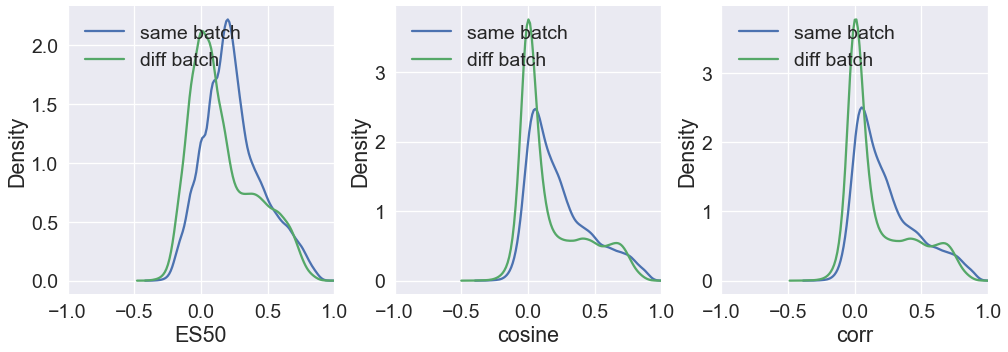

In [107]:
fig = density_plot_scores_same_drug(res_scores1)

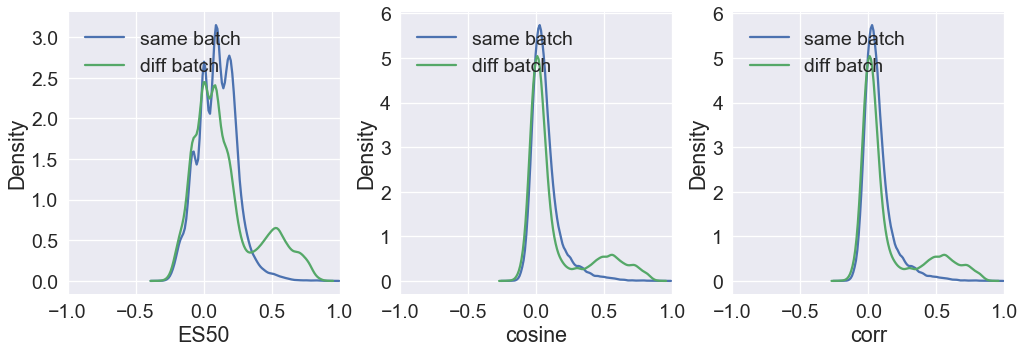

In [108]:
fig = density_plot_scores_same_drug(res_scores2)

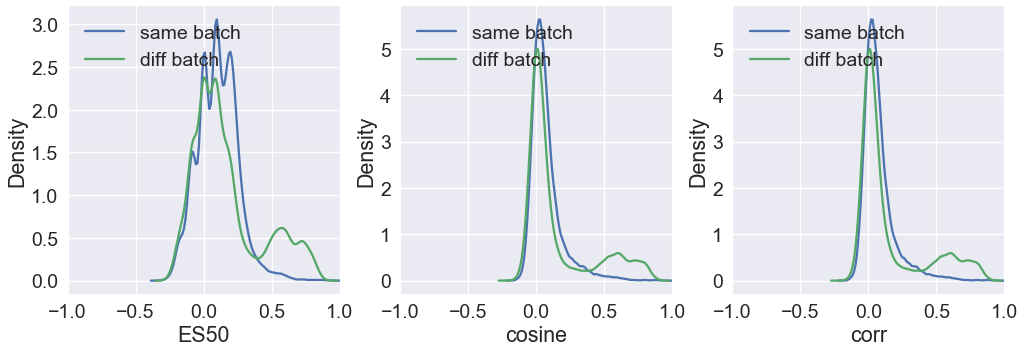

In [109]:
fig = density_plot_scores_same_drug(res_scores3)

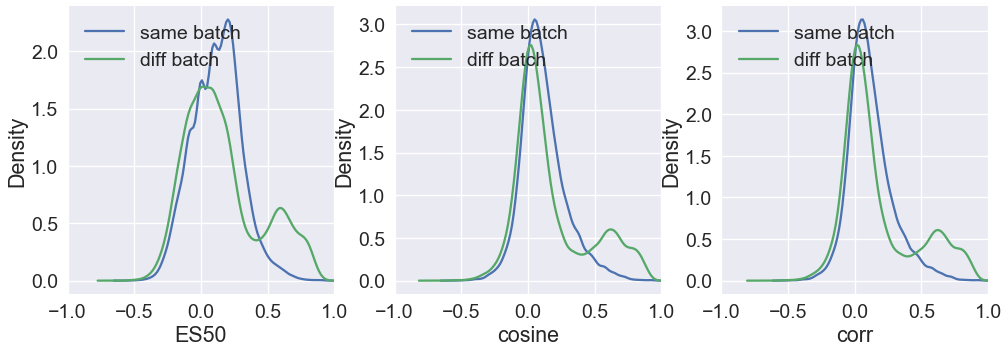

In [110]:
fig = density_plot_scores_same_drug(res_scores4)

# Benchmark using MoA regardless of batch effects

In [21]:
print len(d_pert_name), meta_df['pert_id'].nunique()
pert_ids_with_MoAs = set(d_pert_name) & set(meta_df['pert_id'].unique())
print len(pert_ids_with_MoAs)

6172 5188
1670


In [22]:
meta_df = meta_df.loc[meta_df['pert_id'].isin(pert_ids_with_MoAs)]
print meta_df.shape

meta_df_fwd = meta_df_fwd.loc[meta_df_fwd['pert_id'].isin(pert_ids_with_MoAs)]
print meta_df_fwd.shape

(42461, 5)
(42461, 5)


In [23]:
meta_df = meta_df.sort_index()
meta_df_fwd = meta_df_fwd.sort_index()

In [32]:
# sample 10000 sig_ids for this benchmark
random_idx = np.random.choice(range(meta_df.shape[0]), 5000, replace=False)
meta_df_sample = meta_df.iloc[random_idx]
meta_df_fwd_sample = meta_df_fwd.iloc[random_idx]
print meta_df_sample.shape, meta_df_fwd_sample.shape

(5000, 5) (5000, 5)


In [33]:
def compute_pscores(meta_df, coll, key, n_jobs=1):
    '''Given a meta_df of signatures, compute the pairwise scores and return a df.'''
    sig_ids = meta_df.index.tolist()
    sig_mat = retrieve_sig_mat(sig_ids, coll, key)
    print 'sig_mat retrieved'

    scores_es50 = pscore(sig_mat, gsea_score, n_jobs=n_jobs, n_sig=50)

    scores_cosine = pscore(sig_mat, cosine_sim, n_jobs=n_jobs)
    scores_corr = pscore(sig_mat, correlation, n_jobs=n_jobs)
    
    print 'scores computed'
    n_scores = len(scores_cosine)
    sigs_i = [None] * n_scores
    sigs_j = [None] * n_scores
    c = 0
    for sig_i, sig_j in combinations(sig_ids, 2):
        sigs_i[c] = sig_i
        sigs_j[c] = sig_j
        c += 1

    df = pd.DataFrame({
        'sig_i': sigs_i, 'sig_j': sigs_j, 
        'cosine': scores_cosine,
        'corr': scores_corr,
        'ES50': scores_es50
    })
    return df

In [31]:
res_scores1 = compute_pscores(meta_df_sample, coll, 'chdirLm')
print res_scores1.shape
res_scores1.head()

sig_mat retrieved


[Parallel(n_jobs=7)]: Done   1 out of  41 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  24 out of 150 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=7)]: Done 146 out of 494 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=7)]: Done 154 out of 509 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=7)]: Done 199796 out of 499500 | elapsed:  1.7min remaining:  2.5min
[Parallel(n_jobs=7)]: Done 249747 out of 499500 | elapsed:  2.2min remaining:  2.2min
[Parallel(n_jobs=7)]: Done 299698 out of 499500 | elapsed:  2.5min remaining:  1.7min
[Parallel(n_jobs=7)]: Done 349649 out of 499500 | elapsed:  2.8min remaining:  1.2min
[Parallel(n_jobs=7)]: Done 399600 out of 499500 | elapsed:  3.0min remaining:   45.7s
[Parallel(n_jobs=7)]: Done 449551 out of 499500 | elapsed:  3.3min remaining:   22.1s
[Parallel(n_jobs=7)]: Done 499500 out of 499500 | elapsed:  3.6min finished
[Parallel(n_jobs=7)]: Done   1 out of  42 | elapsed:    0.0s remaining:    0.2s
[Paralle

scores computed
(499500, 5)


,ES50,corr,cosine,sig_i,sig_j
0,0.077371,0.055764,0.049388,CPC014_VCAP_6H:BRD-K66956375:10.0,CPC006_PL21_6H:BRD-K39503511:80.0
1,-0.070593,0.007208,0.006479,CPC014_VCAP_6H:BRD-K66956375:10.0,CPC006_MCF7_6H:BRD-A04352665:10.0
2,0.004472,0.038193,0.038220,CPC014_VCAP_6H:BRD-K66956375:10.0,CPC006_TYKNU_6H:BRD-K67844266:11.1
3,0.058782,0.101914,0.093393,CPC014_VCAP_6H:BRD-K66956375:10.0,CPC002_VCAP_6H:BRD-K15164005:10.0
4,0.030744,0.015664,0.021512,CPC014_VCAP_6H:BRD-K66956375:10.0,CPC006_CL34_6H:BRD-K04623885:80.0


In [ ]:
res_scores1 = compute_pscores(meta_df_sample, coll, 'chdirLm')
print res_scores1.shape
res_scores1.head()

sig_mat retrieved


[Parallel(n_jobs=7)]: Done   1 out of  49 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=7)]: Done   7 out of  68 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  11 out of  73 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  25 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  31 out of 120 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  86 out of 301 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  87 out of 302 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  92 out of 321 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  93 out of 322 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=7)]: Done 101 out of 337 | elapsed:    0.0s remaining:    0.1s


In [ ]:
res_scores2 = compute_pscores(meta_df_fwd_sample, coll, 'chdirLm')
print res_scores2.shape

In [131]:
sig_ids = meta_df_sample.index.tolist()
sig_mat = retrieve_sig_mat(sig_ids, coll, 'chdirLm')
print sig_mat.shape

(10000, 978)


In [139]:
from sklearn.metrics import pairwise_distances, pairwise

In [134]:
D = pairwise_distances(sig_mat, metric='cosine', n_jobs=1)
print D.shape

(10000, 10000)


In [135]:
D = pairwise_distances(sig_mat, metric='correlation', n_jobs=1)
print D.shape

(10000, 10000)


In [136]:
%%timeit
D = pairwise_distances(sig_mat, metric='cosine')

1 loop, best of 3: 1.93 s per loop


In [158]:
D = pairwise.cosine_similarity(sig_mat)

In [150]:
%%timeit
pscore(sig_mat[:100], cosine_sim)

10 loops, best of 3: 88.4 ms per loop


In [151]:
%%timeit
pscore(sig_mat[:200], cosine_sim)

1 loop, best of 3: 361 ms per loop


In [154]:
%%timeit
pscore(sig_mat[:400], cosine_sim)

1 loop, best of 3: 1.43 s per loop


In [156]:
100 ** 2 * 84 / 1000 /60. # min

14.0

In [159]:
%%timeit
pscore(sig_mat[:100], lambda x, y: gsea_score(x, y, 50))

1 loop, best of 3: 1.73 s per loop


In [162]:
20 ** 2 * 1730 / 1000 /60. # min

11.533333333333333